# Training the Object Detector

In [8]:
!pip install -q gluoncv

In [2]:
import gluoncv as gcv
import mxnet as mx

# Preparing the Training Dataset

In [3]:
import os

class DetectionDataset(gcv.data.VOCDetection):
    CLASSES = ['cocacola', 'juice', 'noodles', 'hand']  # , 'cocacola-zero'
    def __init__(self, root):
        self._im_shapes = {}
        self._root = os.path.expanduser(root)
        self._transform = None
        self._items = [(self._root, x.strip('.xml')) for x in os.listdir(self._root) if x.endswith('.xml')]
        self._anno_path = os.path.join('{}', '{}.xml')
        self._image_path = os.path.join('{}', '{}.jpg')
        self.index_map = dict(zip(self.classes, range(self.num_class)))
        self._label_cache = self._preload_labels()
        
    def __str__(self):
        detail = self._root
        return self.__class__.__name__ + '(' + detail + ')'
    
    @property
    def classes(self):
        return self.CLASSES
    
    @property
    def num_class(self):
        return len(self.classes)
        
train_dataset = DetectionDataset('../images/v4')
print('class_names:', train_dataset.classes)
print('num_images:', len(train_dataset))

class_names: ['cocacola', 'juice', 'noodles', 'hand']
num_images: 117


# Visualizing an Image

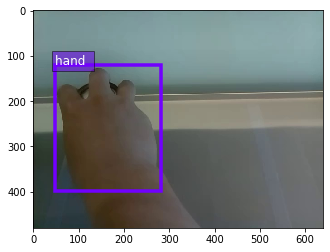

In [4]:
from matplotlib import pyplot as plt
from gluoncv.utils import viz

sample = train_dataset[0]
train_image = sample[0]
train_label = sample[1]

ax = viz.plot_bbox(
    train_image.asnumpy(),
    train_label[:, :4],
    labels=train_label[:, 4:5],
    class_names=train_dataset.classes)
plt.show()


## Model Training
### Training Functions

In [5]:
import time
from datetime import datetime
from mxnet import autograd
from gluoncv.data.batchify import Tuple, Stack, Pad

def train_model(train_dataset, epochs=50):
    ctx = mx.gpu(0)
#     ctx = mx.cpu(0)
    net = gcv.model_zoo.get_model('yolo3_darknet53_custom', classes=train_dataset.classes, transfer='coco')
    #net.load_parameters('object_detector_epoch100_10_23_2019_21_59_13.params')  # TODO continue training
    net.collect_params().reset_ctx(ctx)
    width, height = 512, 512  # suppose we use 512 as base training size
    gcv.utils.random.seed(233)
    
#     batch_size = 4
    batch_size = 8  # 16 for p3.2xlarge, 8 for p2.2xlarge
    # you can make it larger(if your CPU has more cores) to accelerate data loading
    num_workers = 4

    train_transform = gcv.data.transforms.presets.yolo.YOLO3DefaultTrainTransform(width, height, net)
    batchify_fn = Tuple(*([Stack() for _ in range(6)] + [Pad(axis=0, pad_val=-1) for _ in range(1)]))
    train_loader = mx.gluon.data.DataLoader(
        train_dataset.transform(train_transform),
        batch_size,
        shuffle=True,
        batchify_fn=batchify_fn,
        last_batch='rollover',
        num_workers=num_workers)
    
    sigmoid_ce = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
    l1_loss = mx.gluon.loss.L1Loss()
    obj_metrics = mx.metric.Loss('ObjLoss')
    center_metrics = mx.metric.Loss('BoxCenterLoss')
    scale_metrics = mx.metric.Loss('BoxScaleLoss')
    cls_metrics = mx.metric.Loss('ClassLoss')
    for k, v in net.collect_params().items():
        if 'yolodetectionblock' not in k and 'yolooutput' not in k:
            # freeze upper layers
            v.grad_req = 'null'
    trainer = mx.gluon.Trainer(
        net.collect_params(), 'sgd',
        {'learning_rate': 0.0005, 'wd': 0.0005, 'momentum': 0.9})  # 'learning_rate': 0.001
    
    net.hybridize(static_alloc=True, static_shape=True)
    
    for epoch in range(epochs):
        tic = time.time()
        btic = time.time()
        
        for i, batch in enumerate(train_loader):
            batch_size = batch[0].shape[0]
            data = mx.gluon.utils.split_and_load(batch[0], ctx_list=[ctx], batch_axis=0)
            # objectness, center_targets, scale_targets, weights, class_targets
            fixed_targets = [mx.gluon.utils.split_and_load(batch[it], ctx_list=[ctx], batch_axis=0) for it in range(1, 6)]
            gt_boxes = mx.gluon.utils.split_and_load(batch[6], ctx_list=[ctx], batch_axis=0)
            sum_losses = []
            obj_losses = []
            center_losses = []
            scale_losses = []
            cls_losses = []
            
            with autograd.record():
                for ix, x in enumerate(data):
                    obj_loss, center_loss, scale_loss, cls_loss = net(x, gt_boxes[ix], *[ft[ix] for ft in fixed_targets])
                    sum_losses.append(obj_loss + center_loss + scale_loss + cls_loss)
                    obj_losses.append(obj_loss)
                    center_losses.append(center_loss)
                    scale_losses.append(scale_loss)
                    cls_losses.append(cls_loss)
                autograd.backward(sum_losses)
            trainer.step(batch_size)
            obj_metrics.update(0, obj_losses)
            center_metrics.update(0, center_losses)
            scale_metrics.update(0, scale_losses)
            cls_metrics.update(0, cls_losses)
            name1, loss1 = obj_metrics.get()
            name2, loss2 = center_metrics.get()
            name3, loss3 = scale_metrics.get()
            name4, loss4 = cls_metrics.get()
            print('[Epoch {}][Batch {}], LR: {:.2E}, Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}, {}={:.3f}, {}={:.3f}'.format(
                epoch, i, trainer.learning_rate, batch_size/(time.time()-btic), name1, loss1, name2, loss2, name3, loss3, name4, loss4))
            btic = time.time()
    return net
        


### Training an Object Detector

In [6]:
epochs = 100
net = train_model(train_dataset, epochs=epochs)
save_file = 'object_detector_epoch{}_{}.params'.format(epochs, datetime.now().strftime("%m_%d_%Y_%H_%M_%S"))
net.save_parameters(save_file)
print('Saved model to disk: ' + save_file)

100%|██████████| 224190/224190 [00:04<00:00, 48885.41KB/s]


[Epoch 0][Batch 0], LR: 5.00E-04, Speed: 0.319 samples/sec, ObjLoss=11882.013, BoxCenterLoss=10.552, BoxScaleLoss=6.286, ClassLoss=11.263
[Epoch 0][Batch 1], LR: 5.00E-04, Speed: 12.286 samples/sec, ObjLoss=5977.810, BoxCenterLoss=9.273, BoxScaleLoss=5.124, ClassLoss=9.557
[Epoch 0][Batch 2], LR: 5.00E-04, Speed: 13.140 samples/sec, ObjLoss=3994.782, BoxCenterLoss=8.479, BoxScaleLoss=4.502, ClassLoss=8.778
[Epoch 0][Batch 3], LR: 5.00E-04, Speed: 13.205 samples/sec, ObjLoss=3012.282, BoxCenterLoss=8.993, BoxScaleLoss=4.608, ClassLoss=9.236
[Epoch 0][Batch 4], LR: 5.00E-04, Speed: 12.730 samples/sec, ObjLoss=2423.242, BoxCenterLoss=8.716, BoxScaleLoss=4.477, ClassLoss=8.817
[Epoch 0][Batch 5], LR: 5.00E-04, Speed: 13.445 samples/sec, ObjLoss=2031.580, BoxCenterLoss=9.476, BoxScaleLoss=4.823, ClassLoss=9.229
[Epoch 0][Batch 6], LR: 5.00E-04, Speed: 13.263 samples/sec, ObjLoss=1749.090, BoxCenterLoss=10.093, BoxScaleLoss=5.072, ClassLoss=9.703
[Epoch 0][Batch 7], LR: 5.00E-04, Speed: 13.3

[Epoch 4][Batch 3], LR: 5.00E-04, Speed: 12.365 samples/sec, ObjLoss=230.704, BoxCenterLoss=9.569, BoxScaleLoss=3.189, ClassLoss=7.420
[Epoch 4][Batch 4], LR: 5.00E-04, Speed: 12.052 samples/sec, ObjLoss=227.237, BoxCenterLoss=9.595, BoxScaleLoss=3.181, ClassLoss=7.411
[Epoch 4][Batch 5], LR: 5.00E-04, Speed: 12.853 samples/sec, ObjLoss=223.808, BoxCenterLoss=9.515, BoxScaleLoss=3.148, ClassLoss=7.344
[Epoch 4][Batch 6], LR: 5.00E-04, Speed: 12.219 samples/sec, ObjLoss=220.584, BoxCenterLoss=9.482, BoxScaleLoss=3.135, ClassLoss=7.293
[Epoch 4][Batch 7], LR: 5.00E-04, Speed: 13.361 samples/sec, ObjLoss=218.059, BoxCenterLoss=9.483, BoxScaleLoss=3.133, ClassLoss=7.290
[Epoch 4][Batch 8], LR: 5.00E-04, Speed: 13.296 samples/sec, ObjLoss=215.364, BoxCenterLoss=9.454, BoxScaleLoss=3.116, ClassLoss=7.269
[Epoch 4][Batch 9], LR: 5.00E-04, Speed: 13.410 samples/sec, ObjLoss=212.612, BoxCenterLoss=9.449, BoxScaleLoss=3.101, ClassLoss=7.248
[Epoch 4][Batch 10], LR: 5.00E-04, Speed: 13.290 sample

[Epoch 8][Batch 5], LR: 5.00E-04, Speed: 12.141 samples/sec, ObjLoss=126.670, BoxCenterLoss=9.280, BoxScaleLoss=2.649, ClassLoss=6.338
[Epoch 8][Batch 6], LR: 5.00E-04, Speed: 13.023 samples/sec, ObjLoss=125.914, BoxCenterLoss=9.294, BoxScaleLoss=2.654, ClassLoss=6.339
[Epoch 8][Batch 7], LR: 5.00E-04, Speed: 13.459 samples/sec, ObjLoss=125.005, BoxCenterLoss=9.319, BoxScaleLoss=2.653, ClassLoss=6.344
[Epoch 8][Batch 8], LR: 5.00E-04, Speed: 13.161 samples/sec, ObjLoss=124.054, BoxCenterLoss=9.294, BoxScaleLoss=2.641, ClassLoss=6.311
[Epoch 8][Batch 9], LR: 5.00E-04, Speed: 13.169 samples/sec, ObjLoss=123.132, BoxCenterLoss=9.277, BoxScaleLoss=2.636, ClassLoss=6.277
[Epoch 8][Batch 10], LR: 5.00E-04, Speed: 13.326 samples/sec, ObjLoss=122.222, BoxCenterLoss=9.259, BoxScaleLoss=2.627, ClassLoss=6.246
[Epoch 8][Batch 11], LR: 5.00E-04, Speed: 13.174 samples/sec, ObjLoss=121.385, BoxCenterLoss=9.241, BoxScaleLoss=2.619, ClassLoss=6.237
[Epoch 8][Batch 12], LR: 5.00E-04, Speed: 13.376 samp

[Epoch 12][Batch 8], LR: 5.00E-04, Speed: 13.215 samples/sec, ObjLoss=90.178, BoxCenterLoss=9.098, BoxScaleLoss=2.462, ClassLoss=5.596
[Epoch 12][Batch 9], LR: 5.00E-04, Speed: 13.296 samples/sec, ObjLoss=89.725, BoxCenterLoss=9.089, BoxScaleLoss=2.457, ClassLoss=5.580
[Epoch 12][Batch 10], LR: 5.00E-04, Speed: 13.405 samples/sec, ObjLoss=89.288, BoxCenterLoss=9.083, BoxScaleLoss=2.454, ClassLoss=5.566
[Epoch 12][Batch 11], LR: 5.00E-04, Speed: 13.309 samples/sec, ObjLoss=88.974, BoxCenterLoss=9.091, BoxScaleLoss=2.453, ClassLoss=5.573
[Epoch 12][Batch 12], LR: 5.00E-04, Speed: 13.322 samples/sec, ObjLoss=88.528, BoxCenterLoss=9.085, BoxScaleLoss=2.457, ClassLoss=5.552
[Epoch 12][Batch 13], LR: 5.00E-04, Speed: 13.263 samples/sec, ObjLoss=88.110, BoxCenterLoss=9.077, BoxScaleLoss=2.456, ClassLoss=5.541
[Epoch 12][Batch 14], LR: 5.00E-04, Speed: 13.164 samples/sec, ObjLoss=87.726, BoxCenterLoss=9.067, BoxScaleLoss=2.449, ClassLoss=5.529
[Epoch 13][Batch 0], LR: 5.00E-04, Speed: 4.287 sa

[Epoch 16][Batch 10], LR: 5.00E-04, Speed: 13.301 samples/sec, ObjLoss=70.207, BoxCenterLoss=8.938, BoxScaleLoss=2.346, ClassLoss=5.090
[Epoch 16][Batch 11], LR: 5.00E-04, Speed: 13.179 samples/sec, ObjLoss=69.953, BoxCenterLoss=8.931, BoxScaleLoss=2.346, ClassLoss=5.082
[Epoch 16][Batch 12], LR: 5.00E-04, Speed: 13.192 samples/sec, ObjLoss=69.718, BoxCenterLoss=8.935, BoxScaleLoss=2.348, ClassLoss=5.073
[Epoch 16][Batch 13], LR: 5.00E-04, Speed: 13.302 samples/sec, ObjLoss=69.494, BoxCenterLoss=8.942, BoxScaleLoss=2.345, ClassLoss=5.076
[Epoch 17][Batch 0], LR: 5.00E-04, Speed: 4.042 samples/sec, ObjLoss=69.258, BoxCenterLoss=8.949, BoxScaleLoss=2.347, ClassLoss=5.073
[Epoch 17][Batch 1], LR: 5.00E-04, Speed: 13.024 samples/sec, ObjLoss=69.002, BoxCenterLoss=8.944, BoxScaleLoss=2.346, ClassLoss=5.063
[Epoch 17][Batch 2], LR: 5.00E-04, Speed: 11.535 samples/sec, ObjLoss=68.753, BoxCenterLoss=8.937, BoxScaleLoss=2.343, ClassLoss=5.053
[Epoch 17][Batch 3], LR: 5.00E-04, Speed: 11.952 sam

[Epoch 20][Batch 13], LR: 5.00E-04, Speed: 13.177 samples/sec, ObjLoss=58.131, BoxCenterLoss=8.889, BoxScaleLoss=2.291, ClassLoss=4.773
[Epoch 20][Batch 14], LR: 5.00E-04, Speed: 13.334 samples/sec, ObjLoss=57.973, BoxCenterLoss=8.890, BoxScaleLoss=2.288, ClassLoss=4.773
[Epoch 21][Batch 0], LR: 5.00E-04, Speed: 4.072 samples/sec, ObjLoss=57.810, BoxCenterLoss=8.883, BoxScaleLoss=2.285, ClassLoss=4.766
[Epoch 21][Batch 1], LR: 5.00E-04, Speed: 11.348 samples/sec, ObjLoss=57.664, BoxCenterLoss=8.885, BoxScaleLoss=2.286, ClassLoss=4.766
[Epoch 21][Batch 2], LR: 5.00E-04, Speed: 11.141 samples/sec, ObjLoss=57.497, BoxCenterLoss=8.883, BoxScaleLoss=2.285, ClassLoss=4.760
[Epoch 21][Batch 3], LR: 5.00E-04, Speed: 12.218 samples/sec, ObjLoss=57.332, BoxCenterLoss=8.876, BoxScaleLoss=2.281, ClassLoss=4.755
[Epoch 21][Batch 4], LR: 5.00E-04, Speed: 11.650 samples/sec, ObjLoss=57.176, BoxCenterLoss=8.877, BoxScaleLoss=2.280, ClassLoss=4.751
[Epoch 21][Batch 5], LR: 5.00E-04, Speed: 12.713 sampl

[Epoch 25][Batch 1], LR: 5.00E-04, Speed: 11.901 samples/sec, ObjLoss=49.687, BoxCenterLoss=8.808, BoxScaleLoss=2.190, ClassLoss=4.491
[Epoch 25][Batch 2], LR: 5.00E-04, Speed: 12.043 samples/sec, ObjLoss=49.581, BoxCenterLoss=8.806, BoxScaleLoss=2.190, ClassLoss=4.486
[Epoch 25][Batch 3], LR: 5.00E-04, Speed: 11.291 samples/sec, ObjLoss=49.458, BoxCenterLoss=8.808, BoxScaleLoss=2.190, ClassLoss=4.478
[Epoch 25][Batch 4], LR: 5.00E-04, Speed: 12.141 samples/sec, ObjLoss=49.333, BoxCenterLoss=8.801, BoxScaleLoss=2.187, ClassLoss=4.469
[Epoch 25][Batch 5], LR: 5.00E-04, Speed: 13.003 samples/sec, ObjLoss=49.213, BoxCenterLoss=8.801, BoxScaleLoss=2.188, ClassLoss=4.463
[Epoch 25][Batch 6], LR: 5.00E-04, Speed: 12.829 samples/sec, ObjLoss=49.100, BoxCenterLoss=8.799, BoxScaleLoss=2.187, ClassLoss=4.457
[Epoch 25][Batch 7], LR: 5.00E-04, Speed: 13.193 samples/sec, ObjLoss=49.011, BoxCenterLoss=8.803, BoxScaleLoss=2.186, ClassLoss=4.457
[Epoch 25][Batch 8], LR: 5.00E-04, Speed: 13.094 sample

[Epoch 29][Batch 3], LR: 5.00E-04, Speed: 12.413 samples/sec, ObjLoss=43.605, BoxCenterLoss=8.778, BoxScaleLoss=2.126, ClassLoss=4.271
[Epoch 29][Batch 4], LR: 5.00E-04, Speed: 12.853 samples/sec, ObjLoss=43.515, BoxCenterLoss=8.772, BoxScaleLoss=2.123, ClassLoss=4.267
[Epoch 29][Batch 5], LR: 5.00E-04, Speed: 13.079 samples/sec, ObjLoss=43.424, BoxCenterLoss=8.765, BoxScaleLoss=2.122, ClassLoss=4.260
[Epoch 29][Batch 6], LR: 5.00E-04, Speed: 13.167 samples/sec, ObjLoss=43.342, BoxCenterLoss=8.769, BoxScaleLoss=2.122, ClassLoss=4.259
[Epoch 29][Batch 7], LR: 5.00E-04, Speed: 13.331 samples/sec, ObjLoss=43.250, BoxCenterLoss=8.767, BoxScaleLoss=2.121, ClassLoss=4.253
[Epoch 29][Batch 8], LR: 5.00E-04, Speed: 13.148 samples/sec, ObjLoss=43.165, BoxCenterLoss=8.762, BoxScaleLoss=2.120, ClassLoss=4.249
[Epoch 29][Batch 9], LR: 5.00E-04, Speed: 13.289 samples/sec, ObjLoss=43.095, BoxCenterLoss=8.767, BoxScaleLoss=2.120, ClassLoss=4.248
[Epoch 29][Batch 10], LR: 5.00E-04, Speed: 13.366 sampl

[Epoch 33][Batch 6], LR: 5.00E-04, Speed: 12.566 samples/sec, ObjLoss=39.099, BoxCenterLoss=8.786, BoxScaleLoss=2.087, ClassLoss=4.147
[Epoch 33][Batch 7], LR: 5.00E-04, Speed: 12.689 samples/sec, ObjLoss=39.034, BoxCenterLoss=8.786, BoxScaleLoss=2.085, ClassLoss=4.147
[Epoch 33][Batch 8], LR: 5.00E-04, Speed: 13.189 samples/sec, ObjLoss=38.965, BoxCenterLoss=8.783, BoxScaleLoss=2.086, ClassLoss=4.144
[Epoch 33][Batch 9], LR: 5.00E-04, Speed: 13.167 samples/sec, ObjLoss=38.904, BoxCenterLoss=8.786, BoxScaleLoss=2.087, ClassLoss=4.140
[Epoch 33][Batch 10], LR: 5.00E-04, Speed: 13.378 samples/sec, ObjLoss=38.840, BoxCenterLoss=8.790, BoxScaleLoss=2.086, ClassLoss=4.138
[Epoch 33][Batch 11], LR: 5.00E-04, Speed: 13.297 samples/sec, ObjLoss=38.775, BoxCenterLoss=8.787, BoxScaleLoss=2.085, ClassLoss=4.134
[Epoch 33][Batch 12], LR: 5.00E-04, Speed: 13.181 samples/sec, ObjLoss=38.708, BoxCenterLoss=8.786, BoxScaleLoss=2.085, ClassLoss=4.131
[Epoch 33][Batch 13], LR: 5.00E-04, Speed: 13.228 sa

[Epoch 37][Batch 8], LR: 5.00E-04, Speed: 13.285 samples/sec, ObjLoss=35.527, BoxCenterLoss=8.744, BoxScaleLoss=2.048, ClassLoss=3.995
[Epoch 37][Batch 9], LR: 5.00E-04, Speed: 13.295 samples/sec, ObjLoss=35.475, BoxCenterLoss=8.747, BoxScaleLoss=2.048, ClassLoss=3.993
[Epoch 37][Batch 10], LR: 5.00E-04, Speed: 13.290 samples/sec, ObjLoss=35.422, BoxCenterLoss=8.751, BoxScaleLoss=2.048, ClassLoss=3.992
[Epoch 37][Batch 11], LR: 5.00E-04, Speed: 13.343 samples/sec, ObjLoss=35.365, BoxCenterLoss=8.753, BoxScaleLoss=2.048, ClassLoss=3.991
[Epoch 37][Batch 12], LR: 5.00E-04, Speed: 13.286 samples/sec, ObjLoss=35.313, BoxCenterLoss=8.752, BoxScaleLoss=2.048, ClassLoss=3.986
[Epoch 37][Batch 13], LR: 5.00E-04, Speed: 13.239 samples/sec, ObjLoss=35.258, BoxCenterLoss=8.754, BoxScaleLoss=2.048, ClassLoss=3.983
[Epoch 38][Batch 0], LR: 5.00E-04, Speed: 3.800 samples/sec, ObjLoss=35.201, BoxCenterLoss=8.748, BoxScaleLoss=2.046, ClassLoss=3.977
[Epoch 38][Batch 1], LR: 5.00E-04, Speed: 11.668 sam

[Epoch 41][Batch 11], LR: 5.00E-04, Speed: 13.135 samples/sec, ObjLoss=32.529, BoxCenterLoss=8.707, BoxScaleLoss=2.008, ClassLoss=3.845
[Epoch 41][Batch 12], LR: 5.00E-04, Speed: 13.099 samples/sec, ObjLoss=32.491, BoxCenterLoss=8.709, BoxScaleLoss=2.007, ClassLoss=3.846
[Epoch 41][Batch 13], LR: 5.00E-04, Speed: 13.308 samples/sec, ObjLoss=32.445, BoxCenterLoss=8.706, BoxScaleLoss=2.006, ClassLoss=3.844
[Epoch 41][Batch 14], LR: 5.00E-04, Speed: 13.221 samples/sec, ObjLoss=32.414, BoxCenterLoss=8.711, BoxScaleLoss=2.006, ClassLoss=3.846
[Epoch 42][Batch 0], LR: 5.00E-04, Speed: 4.257 samples/sec, ObjLoss=32.366, BoxCenterLoss=8.709, BoxScaleLoss=2.005, ClassLoss=3.842
[Epoch 42][Batch 1], LR: 5.00E-04, Speed: 12.898 samples/sec, ObjLoss=32.322, BoxCenterLoss=8.708, BoxScaleLoss=2.004, ClassLoss=3.839
[Epoch 42][Batch 2], LR: 5.00E-04, Speed: 12.272 samples/sec, ObjLoss=32.280, BoxCenterLoss=8.710, BoxScaleLoss=2.004, ClassLoss=3.839
[Epoch 42][Batch 3], LR: 5.00E-04, Speed: 11.102 sam

[Epoch 45][Batch 13], LR: 5.00E-04, Speed: 13.374 samples/sec, ObjLoss=30.087, BoxCenterLoss=8.650, BoxScaleLoss=1.977, ClassLoss=3.690
[Epoch 46][Batch 0], LR: 5.00E-04, Speed: 2.718 samples/sec, ObjLoss=30.059, BoxCenterLoss=8.652, BoxScaleLoss=1.977, ClassLoss=3.690
[Epoch 46][Batch 1], LR: 5.00E-04, Speed: 12.459 samples/sec, ObjLoss=30.023, BoxCenterLoss=8.654, BoxScaleLoss=1.976, ClassLoss=3.689
[Epoch 46][Batch 2], LR: 5.00E-04, Speed: 12.177 samples/sec, ObjLoss=29.981, BoxCenterLoss=8.654, BoxScaleLoss=1.976, ClassLoss=3.685
[Epoch 46][Batch 3], LR: 5.00E-04, Speed: 13.224 samples/sec, ObjLoss=29.945, BoxCenterLoss=8.654, BoxScaleLoss=1.976, ClassLoss=3.684
[Epoch 46][Batch 4], LR: 5.00E-04, Speed: 12.898 samples/sec, ObjLoss=29.910, BoxCenterLoss=8.655, BoxScaleLoss=1.977, ClassLoss=3.682
[Epoch 46][Batch 5], LR: 5.00E-04, Speed: 12.852 samples/sec, ObjLoss=29.870, BoxCenterLoss=8.655, BoxScaleLoss=1.977, ClassLoss=3.679
[Epoch 46][Batch 6], LR: 5.00E-04, Speed: 12.638 sample

[Epoch 50][Batch 1], LR: 5.00E-04, Speed: 9.347 samples/sec, ObjLoss=27.990, BoxCenterLoss=8.614, BoxScaleLoss=1.953, ClassLoss=3.556
[Epoch 50][Batch 2], LR: 5.00E-04, Speed: 11.326 samples/sec, ObjLoss=27.957, BoxCenterLoss=8.614, BoxScaleLoss=1.952, ClassLoss=3.553
[Epoch 50][Batch 3], LR: 5.00E-04, Speed: 12.435 samples/sec, ObjLoss=27.928, BoxCenterLoss=8.618, BoxScaleLoss=1.952, ClassLoss=3.551
[Epoch 50][Batch 4], LR: 5.00E-04, Speed: 11.776 samples/sec, ObjLoss=27.895, BoxCenterLoss=8.616, BoxScaleLoss=1.951, ClassLoss=3.549
[Epoch 50][Batch 5], LR: 5.00E-04, Speed: 12.505 samples/sec, ObjLoss=27.862, BoxCenterLoss=8.614, BoxScaleLoss=1.952, ClassLoss=3.545
[Epoch 50][Batch 6], LR: 5.00E-04, Speed: 12.786 samples/sec, ObjLoss=27.831, BoxCenterLoss=8.613, BoxScaleLoss=1.951, ClassLoss=3.544
[Epoch 50][Batch 7], LR: 5.00E-04, Speed: 13.235 samples/sec, ObjLoss=27.799, BoxCenterLoss=8.615, BoxScaleLoss=1.950, ClassLoss=3.543
[Epoch 50][Batch 8], LR: 5.00E-04, Speed: 13.193 samples

[Epoch 54][Batch 4], LR: 5.00E-04, Speed: 12.047 samples/sec, ObjLoss=26.197, BoxCenterLoss=8.586, BoxScaleLoss=1.932, ClassLoss=3.443
[Epoch 54][Batch 5], LR: 5.00E-04, Speed: 12.054 samples/sec, ObjLoss=26.169, BoxCenterLoss=8.586, BoxScaleLoss=1.932, ClassLoss=3.441
[Epoch 54][Batch 6], LR: 5.00E-04, Speed: 13.024 samples/sec, ObjLoss=26.142, BoxCenterLoss=8.586, BoxScaleLoss=1.932, ClassLoss=3.440
[Epoch 54][Batch 7], LR: 5.00E-04, Speed: 13.103 samples/sec, ObjLoss=26.117, BoxCenterLoss=8.589, BoxScaleLoss=1.932, ClassLoss=3.440
[Epoch 54][Batch 8], LR: 5.00E-04, Speed: 13.031 samples/sec, ObjLoss=26.090, BoxCenterLoss=8.589, BoxScaleLoss=1.932, ClassLoss=3.437
[Epoch 54][Batch 9], LR: 5.00E-04, Speed: 13.144 samples/sec, ObjLoss=26.061, BoxCenterLoss=8.587, BoxScaleLoss=1.932, ClassLoss=3.434
[Epoch 54][Batch 10], LR: 5.00E-04, Speed: 13.093 samples/sec, ObjLoss=26.032, BoxCenterLoss=8.585, BoxScaleLoss=1.931, ClassLoss=3.431
[Epoch 54][Batch 11], LR: 5.00E-04, Speed: 13.295 samp

[Epoch 58][Batch 6], LR: 5.00E-04, Speed: 12.297 samples/sec, ObjLoss=24.656, BoxCenterLoss=8.541, BoxScaleLoss=1.915, ClassLoss=3.333
[Epoch 58][Batch 7], LR: 5.00E-04, Speed: 13.131 samples/sec, ObjLoss=24.631, BoxCenterLoss=8.539, BoxScaleLoss=1.915, ClassLoss=3.332
[Epoch 58][Batch 8], LR: 5.00E-04, Speed: 13.182 samples/sec, ObjLoss=24.612, BoxCenterLoss=8.541, BoxScaleLoss=1.915, ClassLoss=3.332
[Epoch 58][Batch 9], LR: 5.00E-04, Speed: 13.272 samples/sec, ObjLoss=24.591, BoxCenterLoss=8.540, BoxScaleLoss=1.914, ClassLoss=3.331
[Epoch 58][Batch 10], LR: 5.00E-04, Speed: 13.151 samples/sec, ObjLoss=24.567, BoxCenterLoss=8.539, BoxScaleLoss=1.914, ClassLoss=3.329
[Epoch 58][Batch 11], LR: 5.00E-04, Speed: 13.251 samples/sec, ObjLoss=24.544, BoxCenterLoss=8.542, BoxScaleLoss=1.914, ClassLoss=3.328
[Epoch 58][Batch 12], LR: 5.00E-04, Speed: 13.214 samples/sec, ObjLoss=24.520, BoxCenterLoss=8.538, BoxScaleLoss=1.914, ClassLoss=3.327
[Epoch 58][Batch 13], LR: 5.00E-04, Speed: 13.107 sa

[Epoch 62][Batch 9], LR: 5.00E-04, Speed: 13.213 samples/sec, ObjLoss=23.310, BoxCenterLoss=8.506, BoxScaleLoss=1.887, ClassLoss=3.226
[Epoch 62][Batch 10], LR: 5.00E-04, Speed: 13.139 samples/sec, ObjLoss=23.288, BoxCenterLoss=8.506, BoxScaleLoss=1.886, ClassLoss=3.223
[Epoch 62][Batch 11], LR: 5.00E-04, Speed: 13.274 samples/sec, ObjLoss=23.269, BoxCenterLoss=8.505, BoxScaleLoss=1.886, ClassLoss=3.221
[Epoch 62][Batch 12], LR: 5.00E-04, Speed: 13.071 samples/sec, ObjLoss=23.247, BoxCenterLoss=8.505, BoxScaleLoss=1.885, ClassLoss=3.218
[Epoch 62][Batch 13], LR: 5.00E-04, Speed: 13.141 samples/sec, ObjLoss=23.223, BoxCenterLoss=8.505, BoxScaleLoss=1.885, ClassLoss=3.216
[Epoch 62][Batch 14], LR: 5.00E-04, Speed: 13.082 samples/sec, ObjLoss=23.203, BoxCenterLoss=8.506, BoxScaleLoss=1.885, ClassLoss=3.214
[Epoch 63][Batch 0], LR: 5.00E-04, Speed: 3.381 samples/sec, ObjLoss=23.181, BoxCenterLoss=8.503, BoxScaleLoss=1.884, ClassLoss=3.212
[Epoch 63][Batch 1], LR: 5.00E-04, Speed: 11.835 sa

[Epoch 66][Batch 11], LR: 5.00E-04, Speed: 13.079 samples/sec, ObjLoss=22.108, BoxCenterLoss=8.477, BoxScaleLoss=1.867, ClassLoss=3.131
[Epoch 66][Batch 12], LR: 5.00E-04, Speed: 13.233 samples/sec, ObjLoss=22.090, BoxCenterLoss=8.477, BoxScaleLoss=1.868, ClassLoss=3.130
[Epoch 66][Batch 13], LR: 5.00E-04, Speed: 13.126 samples/sec, ObjLoss=22.072, BoxCenterLoss=8.476, BoxScaleLoss=1.868, ClassLoss=3.128
[Epoch 67][Batch 0], LR: 5.00E-04, Speed: 3.014 samples/sec, ObjLoss=22.052, BoxCenterLoss=8.473, BoxScaleLoss=1.867, ClassLoss=3.126
[Epoch 67][Batch 1], LR: 5.00E-04, Speed: 12.264 samples/sec, ObjLoss=22.033, BoxCenterLoss=8.472, BoxScaleLoss=1.866, ClassLoss=3.124
[Epoch 67][Batch 2], LR: 5.00E-04, Speed: 11.261 samples/sec, ObjLoss=22.015, BoxCenterLoss=8.469, BoxScaleLoss=1.866, ClassLoss=3.122
[Epoch 67][Batch 3], LR: 5.00E-04, Speed: 11.228 samples/sec, ObjLoss=21.995, BoxCenterLoss=8.468, BoxScaleLoss=1.865, ClassLoss=3.120
[Epoch 67][Batch 4], LR: 5.00E-04, Speed: 12.224 samp

[Epoch 70][Batch 14], LR: 5.00E-04, Speed: 13.275 samples/sec, ObjLoss=21.047, BoxCenterLoss=8.450, BoxScaleLoss=1.854, ClassLoss=3.043
[Epoch 71][Batch 0], LR: 5.00E-04, Speed: 4.443 samples/sec, ObjLoss=21.029, BoxCenterLoss=8.450, BoxScaleLoss=1.854, ClassLoss=3.041
[Epoch 71][Batch 1], LR: 5.00E-04, Speed: 11.399 samples/sec, ObjLoss=21.014, BoxCenterLoss=8.448, BoxScaleLoss=1.854, ClassLoss=3.040
[Epoch 71][Batch 2], LR: 5.00E-04, Speed: 12.983 samples/sec, ObjLoss=20.998, BoxCenterLoss=8.445, BoxScaleLoss=1.853, ClassLoss=3.038
[Epoch 71][Batch 3], LR: 5.00E-04, Speed: 11.492 samples/sec, ObjLoss=20.982, BoxCenterLoss=8.448, BoxScaleLoss=1.853, ClassLoss=3.036
[Epoch 71][Batch 4], LR: 5.00E-04, Speed: 11.997 samples/sec, ObjLoss=20.967, BoxCenterLoss=8.449, BoxScaleLoss=1.854, ClassLoss=3.035
[Epoch 71][Batch 5], LR: 5.00E-04, Speed: 12.411 samples/sec, ObjLoss=20.954, BoxCenterLoss=8.449, BoxScaleLoss=1.854, ClassLoss=3.034
[Epoch 71][Batch 6], LR: 5.00E-04, Speed: 11.713 sample

[Epoch 75][Batch 2], LR: 5.00E-04, Speed: 11.543 samples/sec, ObjLoss=20.099, BoxCenterLoss=8.421, BoxScaleLoss=1.836, ClassLoss=2.950
[Epoch 75][Batch 3], LR: 5.00E-04, Speed: 12.409 samples/sec, ObjLoss=20.086, BoxCenterLoss=8.419, BoxScaleLoss=1.836, ClassLoss=2.949
[Epoch 75][Batch 4], LR: 5.00E-04, Speed: 12.057 samples/sec, ObjLoss=20.070, BoxCenterLoss=8.417, BoxScaleLoss=1.835, ClassLoss=2.949
[Epoch 75][Batch 5], LR: 5.00E-04, Speed: 12.942 samples/sec, ObjLoss=20.056, BoxCenterLoss=8.416, BoxScaleLoss=1.834, ClassLoss=2.948
[Epoch 75][Batch 6], LR: 5.00E-04, Speed: 12.575 samples/sec, ObjLoss=20.042, BoxCenterLoss=8.418, BoxScaleLoss=1.835, ClassLoss=2.946
[Epoch 75][Batch 7], LR: 5.00E-04, Speed: 13.062 samples/sec, ObjLoss=20.027, BoxCenterLoss=8.419, BoxScaleLoss=1.835, ClassLoss=2.944
[Epoch 75][Batch 8], LR: 5.00E-04, Speed: 13.279 samples/sec, ObjLoss=20.013, BoxCenterLoss=8.417, BoxScaleLoss=1.834, ClassLoss=2.942
[Epoch 75][Batch 9], LR: 5.00E-04, Speed: 13.299 sample

[Epoch 79][Batch 4], LR: 5.00E-04, Speed: 11.794 samples/sec, ObjLoss=19.247, BoxCenterLoss=8.388, BoxScaleLoss=1.824, ClassLoss=2.865
[Epoch 79][Batch 5], LR: 5.00E-04, Speed: 12.799 samples/sec, ObjLoss=19.235, BoxCenterLoss=8.387, BoxScaleLoss=1.823, ClassLoss=2.864
[Epoch 79][Batch 6], LR: 5.00E-04, Speed: 13.015 samples/sec, ObjLoss=19.223, BoxCenterLoss=8.387, BoxScaleLoss=1.823, ClassLoss=2.864
[Epoch 79][Batch 7], LR: 5.00E-04, Speed: 13.069 samples/sec, ObjLoss=19.208, BoxCenterLoss=8.385, BoxScaleLoss=1.823, ClassLoss=2.862
[Epoch 79][Batch 8], LR: 5.00E-04, Speed: 13.242 samples/sec, ObjLoss=19.194, BoxCenterLoss=8.382, BoxScaleLoss=1.823, ClassLoss=2.860
[Epoch 79][Batch 9], LR: 5.00E-04, Speed: 13.189 samples/sec, ObjLoss=19.182, BoxCenterLoss=8.383, BoxScaleLoss=1.822, ClassLoss=2.859
[Epoch 79][Batch 10], LR: 5.00E-04, Speed: 13.366 samples/sec, ObjLoss=19.168, BoxCenterLoss=8.383, BoxScaleLoss=1.822, ClassLoss=2.857
[Epoch 79][Batch 11], LR: 5.00E-04, Speed: 13.266 samp

[Epoch 83][Batch 7], LR: 5.00E-04, Speed: 12.733 samples/sec, ObjLoss=18.503, BoxCenterLoss=8.356, BoxScaleLoss=1.810, ClassLoss=2.788
[Epoch 83][Batch 8], LR: 5.00E-04, Speed: 13.229 samples/sec, ObjLoss=18.491, BoxCenterLoss=8.356, BoxScaleLoss=1.810, ClassLoss=2.787
[Epoch 83][Batch 9], LR: 5.00E-04, Speed: 13.146 samples/sec, ObjLoss=18.478, BoxCenterLoss=8.356, BoxScaleLoss=1.810, ClassLoss=2.786
[Epoch 83][Batch 10], LR: 5.00E-04, Speed: 13.228 samples/sec, ObjLoss=18.467, BoxCenterLoss=8.355, BoxScaleLoss=1.809, ClassLoss=2.785
[Epoch 83][Batch 11], LR: 5.00E-04, Speed: 13.332 samples/sec, ObjLoss=18.454, BoxCenterLoss=8.355, BoxScaleLoss=1.809, ClassLoss=2.784
[Epoch 83][Batch 12], LR: 5.00E-04, Speed: 13.167 samples/sec, ObjLoss=18.442, BoxCenterLoss=8.353, BoxScaleLoss=1.808, ClassLoss=2.782
[Epoch 83][Batch 13], LR: 5.00E-04, Speed: 13.127 samples/sec, ObjLoss=18.430, BoxCenterLoss=8.353, BoxScaleLoss=1.809, ClassLoss=2.781
[Epoch 83][Batch 14], LR: 5.00E-04, Speed: 13.262 s

[Epoch 87][Batch 9], LR: 5.00E-04, Speed: 13.293 samples/sec, ObjLoss=17.803, BoxCenterLoss=8.328, BoxScaleLoss=1.799, ClassLoss=2.712
[Epoch 87][Batch 10], LR: 5.00E-04, Speed: 13.106 samples/sec, ObjLoss=17.792, BoxCenterLoss=8.326, BoxScaleLoss=1.799, ClassLoss=2.710
[Epoch 87][Batch 11], LR: 5.00E-04, Speed: 13.203 samples/sec, ObjLoss=17.780, BoxCenterLoss=8.324, BoxScaleLoss=1.798, ClassLoss=2.709
[Epoch 87][Batch 12], LR: 5.00E-04, Speed: 13.139 samples/sec, ObjLoss=17.768, BoxCenterLoss=8.323, BoxScaleLoss=1.798, ClassLoss=2.708
[Epoch 87][Batch 13], LR: 5.00E-04, Speed: 13.212 samples/sec, ObjLoss=17.758, BoxCenterLoss=8.323, BoxScaleLoss=1.799, ClassLoss=2.706
[Epoch 87][Batch 14], LR: 5.00E-04, Speed: 13.229 samples/sec, ObjLoss=17.748, BoxCenterLoss=8.324, BoxScaleLoss=1.799, ClassLoss=2.706
[Epoch 88][Batch 0], LR: 5.00E-04, Speed: 3.767 samples/sec, ObjLoss=17.738, BoxCenterLoss=8.324, BoxScaleLoss=1.800, ClassLoss=2.705
[Epoch 88][Batch 1], LR: 5.00E-04, Speed: 12.411 sa

[Epoch 91][Batch 12], LR: 5.00E-04, Speed: 13.311 samples/sec, ObjLoss=17.157, BoxCenterLoss=8.315, BoxScaleLoss=1.796, ClassLoss=2.643
[Epoch 91][Batch 13], LR: 5.00E-04, Speed: 13.280 samples/sec, ObjLoss=17.148, BoxCenterLoss=8.316, BoxScaleLoss=1.796, ClassLoss=2.642
[Epoch 91][Batch 14], LR: 5.00E-04, Speed: 13.275 samples/sec, ObjLoss=17.138, BoxCenterLoss=8.314, BoxScaleLoss=1.796, ClassLoss=2.641
[Epoch 92][Batch 0], LR: 5.00E-04, Speed: 3.893 samples/sec, ObjLoss=17.128, BoxCenterLoss=8.316, BoxScaleLoss=1.796, ClassLoss=2.640
[Epoch 92][Batch 1], LR: 5.00E-04, Speed: 7.401 samples/sec, ObjLoss=17.119, BoxCenterLoss=8.315, BoxScaleLoss=1.796, ClassLoss=2.640
[Epoch 92][Batch 2], LR: 5.00E-04, Speed: 12.754 samples/sec, ObjLoss=17.110, BoxCenterLoss=8.316, BoxScaleLoss=1.796, ClassLoss=2.640
[Epoch 92][Batch 3], LR: 5.00E-04, Speed: 11.452 samples/sec, ObjLoss=17.100, BoxCenterLoss=8.315, BoxScaleLoss=1.796, ClassLoss=2.639
[Epoch 92][Batch 4], LR: 5.00E-04, Speed: 11.360 sampl

[Epoch 95][Batch 14], LR: 5.00E-04, Speed: 13.219 samples/sec, ObjLoss=16.578, BoxCenterLoss=8.294, BoxScaleLoss=1.788, ClassLoss=2.574
[Epoch 96][Batch 0], LR: 5.00E-04, Speed: 4.954 samples/sec, ObjLoss=16.568, BoxCenterLoss=8.294, BoxScaleLoss=1.788, ClassLoss=2.573
[Epoch 96][Batch 1], LR: 5.00E-04, Speed: 12.375 samples/sec, ObjLoss=16.559, BoxCenterLoss=8.294, BoxScaleLoss=1.788, ClassLoss=2.571
[Epoch 96][Batch 2], LR: 5.00E-04, Speed: 11.265 samples/sec, ObjLoss=16.549, BoxCenterLoss=8.292, BoxScaleLoss=1.787, ClassLoss=2.570
[Epoch 96][Batch 3], LR: 5.00E-04, Speed: 10.855 samples/sec, ObjLoss=16.543, BoxCenterLoss=8.291, BoxScaleLoss=1.787, ClassLoss=2.569
[Epoch 96][Batch 4], LR: 5.00E-04, Speed: 12.432 samples/sec, ObjLoss=16.534, BoxCenterLoss=8.291, BoxScaleLoss=1.787, ClassLoss=2.568
[Epoch 96][Batch 5], LR: 5.00E-04, Speed: 12.572 samples/sec, ObjLoss=16.526, BoxCenterLoss=8.292, BoxScaleLoss=1.787, ClassLoss=2.567
[Epoch 96][Batch 6], LR: 5.00E-04, Speed: 12.947 sample